# Context

In these notebooks we are trying to optimise the best model form the selection phase to better target each different phylum. In that sense we are splitting the training and the modeling for the different phylumna.  

This notebook descripes the experiments that where executed in order to optimise for the validation accuracy of the target variable (family).

**The following approach was choosen:**
1. A function to implement 3 different
augmentations was implemented (random, simple and heavy). These where later used when creating the models to test for optimisation
2. These three pretrained models where tested with each of the augmentaion methods
- MobileNetv2
- ResNet50
- EfficientNetB0

3. To adress the imbalance of the Phylum, these approaches where tested:
- Random oversampling was tested with ResNet50, random augmentation
- SMOTE with MobileNetV2, heavy augmentation
- Oversampling by duplication with ResNet50, heavy augmentation


4. Each experiment was run for between 10 and 50 epochs and for every run, the model with the best validation accuracy was saved as a .keras file


5. Solutions: with different approaches, such as ResNet50 with simple augmenation and MobileNetv2 with heavy augmentation, we never reached a score higher than **66%.** This is in coparison to our other Phylums very low.
All the experiments to adress the imbalance ended in worse accuracy. This was due to the fact, that SMOTE works by interpolating between feature vectors — and in the case of image data, flattening breaks the spatial structure, and interpolating pixel-by-pixel can create non-realistic or corrupted images that don't follow the original data distribution.
Basically making this appraoch worthless :/

Our hyphothesis to explain this difference in accuracy compared to our other models is, that cnidaria is a coral and all of the pictures look very similar to each other. That's also why we tried adding noise with the gaussian function from kerase. Unfortunately this did not increase the accuracy as expected.

# Setup and Imports

In [4]:
from google.colab import drive
import zipfile
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/rare_species 1.zip'
extract_path = '/content/rare_species 1'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow import data as tf_data
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Rescaling, RandAugment

from sklearn.metrics import classification_report

In [6]:
# With colab
folder_path = '/content/rare_species 1/rare_species 1'
meta = pd.read_csv('/content/rare_species 1//metadata.csv')

# With vscode
# folder_path = '../data/rare_species 1'
# meta = pd.read_csv('../data/rare_species 1/metadata.csv')

In [7]:
print(f"the diferent Phylum are: \n{meta['phylum'].unique()}")
print(f"each phylum contains :  \n{meta['phylum'].value_counts()}")

print(f"their is {meta['family'].nunique()} different families")

meta

the diferent Phylum are: 
['mollusca' 'chordata' 'arthropoda' 'echinodermata' 'cnidaria']
each phylum contains :  
phylum
chordata         9952
arthropoda        951
cnidaria          810
mollusca          210
echinodermata      60
Name: count, dtype: int64
their is 202 different families


,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...
3,29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-s...
4,94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...
...,...,...,...,...,...,...,...
11978,1fa96ea5-32fa-4a25-b8d2-fa99f6e2cb89,29734618,1011315,animalia,chordata,leporidae,chordata_leporidae/29734618_1011315_eol-full-s...
11979,628bf2b4-6ecc-4017-a8e6-4306849e0cfc,29972861,1056842,animalia,chordata,emydidae,chordata_emydidae/29972861_1056842_eol-full-si...
11980,0ecfdec9-b1cd-4d43-96fc-2f8889ec1ad9,30134195,52572074,animalia,chordata,dasyatidae,chordata_dasyatidae/30134195_52572074_eol-full...
11981,27fdb1e9-c5fb-459a-8b6a-6fb222b1c512,9474963,46559139,animalia,chordata,mustelidae,chordata_mustelidae/9474963_46559139_eol-full-...


# Phylum Splits

This code splits the species into separate folders based on their phylum.  
This organization allows us to train a dedicated model for each phylum more effectively.<br>
(we repeat this proses in each notebook only because we are using colab)

In [8]:
# With colab
current_locations = '/content/rare_species 1'

# with vscode
# current_locations = '../data/rare_species 1'

for _, row in meta.iterrows():

    phylum = row['phylum']
    file_path = row['file_path']


    file_location = os.path.join(current_locations, file_path)

    # create a a detination folder keeping the subfolder structure

        # with colab
    target_folder = os.path.join(phylum, os.path.dirname(file_path))

        # with vscode
    # target_folder = os.path.join("../data" , phylum, os.path.dirname(file_path))

    os.makedirs(target_folder, exist_ok=True)  # Make sure the folder exists

    # Final destination path
    destination = os.path.join(target_folder, os.path.basename(file_path))

    # Copy the file if it exists
    if os.path.exists(file_location):
        shutil.copy2(file_location, destination)
    else:
        print(f"Couldn't find the file: {file_location}")

# Train Val Split

In [9]:
# with colab
path_phylum_cnidaria = "/content/cnidaria"

# with vscode
# path_phylum_chordata = "../data/chordata"

image_size = (224, 224)
seed = 42
batch_size = 32

train_ds_cnidaria, val_ds_cnidaria = keras.utils.image_dataset_from_directory(
    path_phylum_cnidaria,
    validation_split=0.2,
    subset="both",
    seed=seed,
    image_size= image_size,
    batch_size= batch_size
)


Found 810 files belonging to 13 classes.
Using 648 files for training.
Using 162 files for validation.


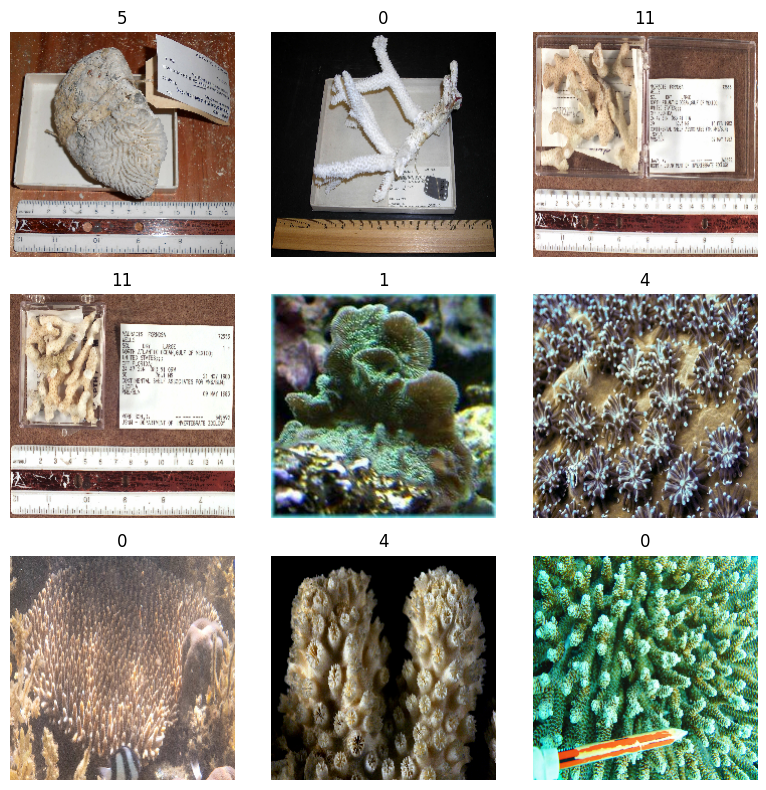

In [12]:
def display_images(train_ds, augmentation_type="simple"):
    for images, labels in train_ds.take(1):
        plt.figure(figsize=(8, 8))
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(int(labels[i]))
            plt.axis("off")
        plt.tight_layout()
        plt.show()

display_images(train_ds_cnidaria)

# Augmentation layer

Functions for Augmentation variants and applying them.

In [10]:
def data_augmentation(images, augmentation_type="simple"):
    augmentation_layer = data_augmentation_layers[augmentation_type]
    return augmentation_layer(images)

In [11]:
# Define different Augemantations to try models with
data_augmentation_layers = {
    # All random Augmentation
    "randaugment": RandAugment(value_range=(0, 255)),
    # Simple, with just random rotation
    "simple": keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
    ]),
    # Heavy, also adding Noise with the Gaussian function
    "heavy": keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.5),
        layers.RandomZoom(0.4),
        layers.RandomContrast(0.3),
        layers.RandomBrightness(factor=0.2),
        layers.RandomShear(fill_mode='reflect'),
        layers.RandomCrop(height=224, width=224),
        layers.GaussianNoise(0.2)
    ])
}

--------------
# Models


Test these 3 different models with simple Augmentation:
1. MobileNetv2
2. ResNet50
3. EfficientNetB0



## MobileNetV2

In [12]:
# Create a function to create mobilenetv2 model
def make_model_mobilenetv2(input_shape, num_classes, augmentation_type="simple"):
    inputs = keras.Input(shape=input_shape)

    # Rescaling layer
    x = data_augmentation(inputs) # Remove the extra (inputs) call here
    x = Rescaling(1./255)(x)

    # Pretrained MobileNetV2 base
    base_model = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False  # Freeze for transfer learning

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)  # Optional regularization

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

In [ ]:
#model_cnidaria = make_model_mobilenetv2(input_shape=image_size + (3,), num_classes=13, augmentation_type="simple")
#keras.utils.plot_model(model_cnidaria, show_shapes=True)

<ipython-input-33-bff34261da3a>:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# re run again with heavy
model_cnidaria = make_model_mobilenetv2(input_shape=image_size + (3,), num_classes=13, augmentation_type="heavy")
#keras.utils.plot_model(model_cnidaria, show_shapes=True)

<ipython-input-11-d8a3bda41a81>:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [15]:
epochs = 10

callbacks = [
    # saves the best model of the run using max val_accuracy as a metric
    keras.callbacks.ModelCheckpoint(
        "best_model_cnidaria_mobilentv2_Heavy_50.keras",
        save_best_only=True,
        monitor="val_acc",
        mode="max",
        verbose=1)
    ]

## change from keras example is the loss function as we deal with a lot of classes
model_cnidaria.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), ## change this CategoricalCrossentropy to the the one it is now
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")], ## change this CategoricalCrossentropy to the the one it is now
)

model_cnidaria.fit(
    train_ds_cnidaria,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds_cnidaria,
)

# get the clasification report
best_model_example = keras.models.load_model("best_model_cnidaria_mobilentv2_Heavy_50.keras")
y_pred_probs = best_model_example.predict(val_ds_cnidaria)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y for x, y in val_ds_cnidaria], axis=0)

print(classification_report(y_true, y_pred))

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.9750 - loss: 0.0831
Epoch 1: val_acc improved from -inf to 0.61111, saving model to best_model_cnidaria_mobilentv2_Heavy_50.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - acc: 0.9750 - loss: 0.0843 - val_acc: 0.6111 - val_loss: 3.4317
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.9752 - loss: 0.0793
Epoch 2: val_acc improved from 0.61111 to 0.62346, saving model to best_model_cnidaria_mobilentv2_Heavy_50.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - acc: 0.9751 - loss: 0.0791 - val_acc: 0.6235 - val_loss: 3.1061
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.9828 - loss: 0.0805
Epoch 3: val_acc improved from 0.62346 to 0.62963, saving model to best_model_cnidaria_mobilentv2_Heavy_50.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - acc: 0.9829 - loss: 0.0794 - val_acc: 0.6296 - val_loss: 2.9987
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.9878 - loss: 0.0353
Epoch 4: val_acc improved from 0.6296

## ResNet50

Experiments:
1. randaugment: val_acc: 0.3827 (stopped early)
2. heavy
3. simple


In [13]:
from tensorflow.keras.applications import ResNet50

In [14]:
# Create a function to create ResNet50 model
def make_model_resnet50(input_shape, num_classes, augmentation_type="simple"):
    inputs = keras.Input(shape=input_shape)

    x = data_augmentation(inputs)
    x = Rescaling(1./255)(x)
    base_model = ResNet50(include_top=False, input_tensor=x, weights="imagenet")
    # Additional preprocessing from imagenet
    # run again without the prepocessing
    #x = keras.applications.imagenet_utils.preprocess_input(x)
    base_model.trainable = False  # Freeze for transfer learning

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)  # Optional regularization

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

In [ ]:
# create model with heavy
model_cnidaria = make_model_resnet50(input_shape=image_size + (3,), num_classes=13, augmentation_type="heavy")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [18]:
#model_cnidaria = make_model_resnet50(input_shape=image_size + (3,), num_classes=13, augmentation_type="randaugment")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [19]:
epochs = 10

callbacks = [
    # saves the best model of the run using max val_accuracy as a metric
    keras.callbacks.ModelCheckpoint(
        "best_model_cnidaria_ResnNet50_random.keras",
        save_best_only=True,
        monitor="val_acc",
        mode="max",
        verbose=1)
    ]

## change from keras example is the loss function as we deal with a lot of classes
model_cnidaria.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), ## change this CategoricalCrossentropy to the the one it is now
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")], ## change this CategoricalCrossentropy to the the one it is now
)

model_cnidaria.fit(
    train_ds_cnidaria,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds_cnidaria,
)

# get the clasification report
best_model_example = keras.models.load_model("best_model_cnidaria_ResnNet50_random.keras")
y_pred_probs = best_model_example.predict(val_ds_cnidaria)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y for x, y in val_ds_cnidaria], axis=0)

print(classification_report(y_true, y_pred))

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - acc: 0.2133 - loss: 3.1137
Epoch 1: val_acc improved from -inf to 0.24691, saving model to best_model_cnidaria_ResnNet50_random.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 168s 8s/step - acc: 0.2138 - loss: 3.1061 - val_acc: 0.2469 - val_loss: 2.8988
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - acc: 0.2517 - loss: 2.4711
Epoch 2: val_acc did not improve from 0.24691
21/21 ━━━━━━━━━━━━━━━━━━━━ 168s 8s/step - acc: 0.2511 - loss: 2.4691 - val_acc: 0.2099 - val_loss: 2.4688
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - acc: 0.2575 - loss: 2.3738
Epoch 3: val_acc improved from 0.24691 to 0.29630, saving model to best_model_cnidaria_ResnNet50_random.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 198s 8s/step - acc: 0.2584 - loss: 2.3706 - val_acc: 0.2963 - val_loss: 2.2129
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - acc: 0.3366 - loss: 2.2412
Epoch 4: val_acc improved from 0.29630 to 0.34568, saving model to best_model_cnidaria_ResnNet50_random.ker

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## EfficientNetB0

Experiments:
1. simple: val_acc: 0.2716
2. heavy: val_acc: 0.2778

In [15]:
from tensorflow.keras.applications import EfficientNetB0

In [16]:
# Create a function to create EfficientNetB0 model
def make_model_efficientnetb0(input_shape, num_classes, augmentation_type="simple"):
    inputs = keras.Input(shape=input_shape)

    x = data_augmentation(inputs)
    x = Rescaling(1./255)(x)
    #x = keras.applications.imagenet_utils.preprocess_input(x) # using the preprocessing from imagenet
    base_model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False  # Freeze for transfer learning

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)  # Optional regularization

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

In [22]:
# simple was val_acc: 0.2716
model_cnidaria = make_model_efficientnetb0(input_shape=image_size + (3,), num_classes=13, augmentation_type="simple")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [23]:
# with heavy:
#model_cnidaria = make_model_efficientnetb0(input_shape=image_size + (3,), num_classes=13, augmentation_type="heavy")

In [24]:
epochs = 10

callbacks = [
    # saves the best model of the run using max val_accuracy as a metric
    keras.callbacks.ModelCheckpoint(
        "best_model_cnidaria_EfficientNetB0_heavy.keras",
        save_best_only=True,
        monitor="val_acc",
        mode="max",
        verbose=1)
    ]

## change from keras example is the loss function as we deal with a lot of classes
model_cnidaria.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), ## change this CategoricalCrossentropy to the the one it is now
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")], ## change this CategoricalCrossentropy to the the one it is now
)

model_cnidaria.fit(
    train_ds_cnidaria,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds_cnidaria,
)

# get the clasification report
best_model_example = keras.models.load_model("best_model_cnidaria_EfficientNetB0_heavy.keras")
y_pred_probs = best_model_example.predict(val_ds_cnidaria)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y for x, y in val_ds_cnidaria], axis=0)

print(classification_report(y_true, y_pred))

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.1329 - loss: 4.6932
Epoch 1: val_acc improved from -inf to 0.27778, saving model to best_model_cnidaria_EfficientNetB0_heavy.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - acc: 0.1322 - loss: 4.6813 - val_acc: 0.2778 - val_loss: 3.5275
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.1946 - loss: 3.1473
Epoch 2: val_acc did not improve from 0.27778
21/21 ━━━━━━━━━━━━━━━━━━━━ 130s 4s/step - acc: 0.1940 - loss: 3.1402 - val_acc: 0.0556 - val_loss: 3.3098
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.1699 - loss: 2.8621
Epoch 3: val_acc did not improve from 0.27778
21/21 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - acc: 0.1711 - loss: 2.8566 - val_acc: 0.0247 - val_loss: 2.9981
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.1435 - loss: 2.8237
Epoch 4: val_acc did not improve from 0.27778
21/21 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - acc: 0.1440 - loss: 2.8235 - val_acc: 0.1235 - val_loss: 2.6189
Epoch 5/10
21/21

6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step
              precision    recall  f1-score   support

           0       0.28      1.00      0.43        45
           1       0.00      0.00      0.00        19
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        20
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00        12
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00        17
          11       0.00      0.00      0.00         9
          12       0.00      0.00      0.00         4

    accuracy                           0.28       162
   macro avg       0.02      0.08      0.03       162
weighted avg       0.08      0.28      0.12       162



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------
# Random over sampling of underrepresented families

Expirements:
1. ResNet50: random augmentation

In [15]:
# Check again to visualize the imbalance
cnidaria_data = meta[meta['phylum'] == 'cnidaria']
family_counts = cnidaria_data['family'].value_counts().reset_index()
family_counts.columns = ['family', 'appearances']

family_counts


,family,appearances
0,acroporidae,210
1,agariciidae,120
2,euphylliidae,90
3,pocilloporidae,60
4,faviidae,60
5,merulinidae,60
6,siderastreidae,30
7,fungiidae,30
8,lobophylliidae,30
9,dendrophylliidae,30


Naive Random Over Sampler was adapted from this Documentation:
https://imbalanced-learn.org/stable/over_sampling.html

In [16]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder

# Convert the dataset to NumPy arrays for RandomOverSampler
X_train = []
y_train = []
for images, labels in train_ds_cnidaria:
    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())
X_train = np.array(X_train)
y_train = np.array(y_train)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train) # Encode labels to numerical values

# Oversample with seed 42 for reproducability
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train_encoded)

# Reshape back to initial image shape
X_train_resampled = X_train_resampled.reshape(-1, 224, 224, 3)

# Convert back to TensorFlow dataset
train_ds_cnidaria_resampled = tf_data.Dataset.from_tensor_slices((X_train_resampled, y_train_resampled))
train_ds_cnidaria_resampled = train_ds_cnidaria_resampled.batch(batch_size)


In [27]:
train_ds_cnidaria_resampled

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [28]:
# Create the model
model_cnidaria = make_model_resnet50(input_shape=image_size + (3,), num_classes=13, augmentation_type="randaugment")

In [29]:
epochs = 10

callbacks = [
    # saves the best model of the run using max val_accuracy as a metric
    keras.callbacks.ModelCheckpoint(
        "best_model_cnidaria_ResNet50_rand_oversampling.keras",
        save_best_only=True,
        monitor="val_acc",
        mode="max",
        verbose=1)
    ]

## change from keras example is the loss function as we deal with a lot of classes
model_cnidaria.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), ## change this CategoricalCrossentropy to the the one it is now
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")], ## change this CategoricalCrossentropy to the the one it is now
)

model_cnidaria.fit(
    train_ds_cnidaria_resampled,  # Use the resampled dataset
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds_cnidaria,
)

# Get the classification report
best_model_example = keras.models.load_model("best_model_cnidaria_ResNet50_rand_oversampling.keras")
y_pred_probs = best_model_example.predict(val_ds_cnidaria)
y_pred_encoded = np.argmax(y_pred_probs, axis=1)  # Predictions are still encoded

# Inverse transform to get original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)
y_true = label_encoder.inverse_transform(np.concatenate([y for x, y in val_ds_cnidaria], axis=0))


print(classification_report(y_true, y_pred))

Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - acc: 0.1823 - loss: 5.6903
Epoch 1: val_acc improved from -inf to 0.05556, saving model to best_model_cnidaria_ResNet50_rand_oversampling.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 414s 6s/step - acc: 0.1813 - loss: 5.7673 - val_acc: 0.0556 - val_loss: 22.9902
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - acc: 0.0915 - loss: 15.7245
Epoch 2: val_acc did not improve from 0.05556
68/68 ━━━━━━━━━━━━━━━━━━━━ 462s 6s/step - acc: 0.0911 - loss: 15.7049 - val_acc: 0.0556 - val_loss: 23.9672
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - acc: 0.1224 - loss: 15.4095
Epoch 3: val_acc improved from 0.05556 to 0.06790, saving model to best_model_cnidaria_ResNet50_rand_oversampling.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 399s 6s/step - acc: 0.1221 - loss: 15.3853 - val_acc: 0.0679 - val_loss: 22.0680
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - acc: 0.1638 - loss: 13.2652
Epoch 4: val_acc improved from 0.06790 to 0.08642, saving model to best_model_c

6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.00      0.00      0.00        19
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        20
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00        12
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         4
           9       0.16      1.00      0.28         5
          10       0.14      0.76      0.23        17
          11       0.17      0.67      0.27         9
          12       0.00      0.00      0.00         4

    accuracy                           0.15       162
   macro avg       0.04      0.19      0.06       162
weighted avg       0.03      0.15      0.05       162



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


------------
# SMOTE

Experiments:
1. MobileNetV2 with simple augmentations (previous functions)
2. After reasearch found, that SMOTE can't work for our problem, because: SMOTE works by interpolating between feature vectors — and in the case of image data, flattening breaks the spatial structure, and interpolating pixel-by-pixel can create non-realistic or corrupted images that don't follow the original data distribution.

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2  # Using MobileNetV2 for simplicity


epochs= 10

callbacks = [
    # saves the best model of the run using max val_accuracy as a metric
    keras.callbacks.ModelCheckpoint(
        "cnidaria_ResNet50_rand_oversampling_heavy.keras",
        save_best_only=True,
        monitor="val_acc",
        mode="max",
        verbose=1)
    ]

# Encode Labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train_encoded)
X_train_resampled = X_train_resampled.reshape(-1, image_size[0], image_size[1], 3) # Reshape back to image dimensions


# use mobiletnetv4 model from pervious runs
#model = make_model_mobilenetv2(input_shape=image_size + (3,), num_classes=13, augmentation_type="simple")
model = make_model_mobilenetv2(input_shape=image_size + (3,), num_classes=13, augmentation_type="heavy")

# compile
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), ## change this CategoricalCrossentropy to the the one it is now
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")], ## change this CategoricalCrossentropy to the the one it is now
)
#fit
model.fit(
    train_ds_cnidaria_resampled,  # Use the resampled dataset
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds_cnidaria,
)

# Get the classification report
best_model_example = keras.models.load_model("cnidaria_ResNet50_rand_oversampling_heavy.keras")
y_pred_probs = best_model_example.predict(val_ds_cnidaria)
y_pred_encoded = np.argmax(y_pred_probs, axis=1)  # Predictions are still encoded

# Inverse transform to get original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)
y_true = label_encoder.inverse_transform(np.concatenate([y for x, y in val_ds_cnidaria], axis=0))


print(classification_report(y_true, y_pred))

___________
# Oversampling by duplication

In [19]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
X_train_image_list = []
y_train_label_list = []
# Extract images and labels from train_ds_cnidaria
for images, labels in train_ds_cnidaria:
    X_train_image_list.append(images.numpy())
    y_train_label_list.append(labels.numpy())
# concatenate the images and labels
X_train = np.concatenate(X_train_image_list, axis=0)
y_train = np.concatenate(y_train_label_list, axis=0)

# encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Check original class distribution
counter = Counter(y_train_encoded)
print("Class distribution:", counter)

Class distribution: Counter({np.int64(0): 165, np.int64(1): 101, np.int64(4): 70, np.int64(11): 51, np.int64(5): 49, np.int64(10): 43, np.int64(7): 26, np.int64(8): 26, np.int64(12): 26, np.int64(2): 25, np.int64(9): 25, np.int64(3): 23, np.int64(6): 18})


In [20]:
import random
# Find max class count
max_count = max(counter.values())

# Oversample by duplication
X_train_oversampled = []
y_train_oversampled = []

for label in np.unique(y_train_encoded):
    # index  = indices belonging to current label
    index = np.where(y_train_encoded == label)[0]
    n_to_add = max_count - len(index) + random.randint(1, 100) # introduce randomness do not normalize all classes
    # calculate how many samples need to be added to current class
    if n_to_add > 0:
        dup_indices = np.random.choice(index , size=n_to_add, replace=True) # randomly choose label to add from the available onces
        X_dup = X_train[dup_indices]
        y_dup = y_train_encoded[dup_indices]
        # concat samples to the list
        X_train_oversampled.append(np.concatenate([X_train[index ], X_dup], axis=0))
        y_train_oversampled.append(np.concatenate([y_train_encoded[index ], y_dup], axis=0))
    else:
        X_train_oversampled.append(X_train[index ])
        y_train_oversampled.append(y_train_encoded[index ])

# Combine all classes
X_train_oversampled = np.concatenate(X_train_oversampled, axis=0)
y_train_oversampled = np.concatenate(y_train_oversampled, axis=0)

# Convert back to tf.data.Dataset -> decoding the labe names
train_ds_cnidaria_oversampled = tf.data.Dataset.from_tensor_slices((X_train_oversampled, y_train_oversampled))
train_ds_cnidaria_oversampled = train_ds_cnidaria_oversampled.batch(batch_size)

# Check new distribution
print("New class distribution:", Counter(y_train_oversampled))

New class distribution: Counter({np.int64(12): 249, np.int64(11): 245, np.int64(4): 236, np.int64(3): 230, np.int64(7): 222, np.int64(8): 222, np.int64(2): 211, np.int64(10): 204, np.int64(6): 190, np.int64(5): 189, np.int64(9): 181, np.int64(1): 175, np.int64(0): 174})


In [21]:
train_ds_cnidaria_oversampled

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

Now we should have 165 of each family

In [22]:
epochs=10
callbacks = [
    # saves the best model of the run using max val_accuracy as a metric
    keras.callbacks.ModelCheckpoint(
        "best_model_cnidaria_ResNet50_oversampling_duplication.keras",
        save_best_only=True,
        monitor="val_acc",
        mode="max",
        verbose=1)
    ]

# re create the model
model = make_model_resnet50(input_shape=image_size + (3,), num_classes=13, augmentation_type="heavy")


## change from keras example is the loss function as we deal with a lot of classes
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), ## change this CategoricalCrossentropy to the the one it is now
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")], ## change this CategoricalCrossentropy to the the one it is now
)

model.fit(
    train_ds_cnidaria_oversampled,  # Oversampled data for training
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds_cnidaria,
)

# Get the classification report
best_model_example = keras.models.load_model("best_model_cnidaria_ResNet50_oversampling_duplication.keras")
y_pred_probs = best_model_example.predict(val_ds_cnidaria)
y_pred_encoded = np.argmax(y_pred_probs, axis=1)  # Predictions are still encoded

# Inverse transform to get original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)
y_true = label_encoder.inverse_transform(np.concatenate([y for x, y in val_ds_cnidaria], axis=0))


print(classification_report(y_true, y_pred))

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - acc: 0.1737 - loss: 14.4594
Epoch 1: val_acc improved from -inf to 0.04321, saving model to best_model_cnidaria_ResNet50_oversampling_duplication.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 527s 6s/step - acc: 0.1723 - loss: 14.5330 - val_acc: 0.0432 - val_loss: 36.0467
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - acc: 0.0020 - loss: 31.6895
Epoch 2: val_acc improved from 0.04321 to 0.05556, saving model to best_model_cnidaria_ResNet50_oversampling_duplication.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 551s 6s/step - acc: 0.0022 - loss: 31.6308 - val_acc: 0.0556 - val_loss: 28.6682
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - acc: 0.0157 - loss: 21.8140
Epoch 3: val_acc did not improve from 0.05556
86/86 ━━━━━━━━━━━━━━━━━━━━ 557s 6s/step - acc: 0.0160 - loss: 21.8147 - val_acc: 0.0494 - val_loss: 28.2823
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - acc: 0.0130 - loss: 25.1933
Epoch 4: val_acc improved from 0.05556 to 0.06173, saving model

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
